# Tutorial: optimal piecewise binning with binary target

## Basic

To get us started, let's load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the binary target.

In [3]:
variable = "mean radius"
x = df[variable].values
y = data.target

Import and instantiate an ``OptimalPWBinning`` object class and we pass the variable name. The ``OptimalPWBinning`` can **ONLY** handle numerical variables. This differs from the ``OptimalBinning`` object class.

In [4]:
from optbinning import OptimalPWBinning

In [5]:
optb = OptimalPWBinning(name=variable)

We fit the optimal binning object with arrays ``x`` and ``y``. We set a minimum (lower bound) and maximum (upper bound) probability using arguments ``lb`` and ``ub``. Note that these bounds are optional, but guarantee an event rate between $[0, 1]$ as any probability distribution. As shown later, settings these bounds will increase the problem size thus leading to higher solution times. An alternative approach to bypass these bounds is implemented when transforming to event rate or WoE using functions ``fit`` and ``fit_transform``, where values outside the interval $[0, 1]$ are clipped.

Note that the Weight-of-Evidence is not defined for event rate equal 0 or 1. Therefore, for small datasets, we recommend modifying the interval $[0, 1]$ with a small value, thus using $[\epsilon, 1 - \epsilon]$.

In [6]:
optb.fit(x, y, lb=0.001, ub=0.999)

OptimalPWBinning(estimator=LogisticRegression(), name='mean radius')

You can check if an optimal solution has been found via the ``status`` attribute:

In [7]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [8]:
optb.splits

array([11.42500019, 12.32999992, 13.09499979, 13.70499992, 15.04500008,
       16.92500019])

#### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``OptimalPWBinning`` returns an object ``PWBinningTable`` via the ``binning_table`` attribute.

In [9]:
binning_table = optb.binning_table

In [10]:
type(binning_table)

optbinning.binning.piecewise.binning_statistics.PWBinningTable

The `binning_table` is instantiated, but not built. Therefore, the first step is to call the method `build`, which returns a ``pandas.DataFrame``.

In [11]:
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,c0,c1
0,"(-inf, 11.43)",118,0.207381,3,115,1.032648,-0.004820
1,"[11.43, 12.33)",79,0.138840,3,76,1.644837,-0.058403
2,"[12.33, 13.09)",68,0.119508,7,61,2.140569,-0.098609
3,"[13.09, 13.70)",49,0.086116,10,39,2.914961,-0.157745
4,"[13.70, 15.05)",83,0.145870,28,55,4.105273,-0.244597
5,"[15.05, 16.93)",54,0.094903,44,10,3.562494,-0.208520
6,"[16.93, inf)",118,0.207381,117,1,0.082142,-0.002887
7,Special,0,0.000000,0,0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.000000
Totals,,569,1.000000,212,357,-,-


Let's describe the columns of this binning table:

- Bin: the intervals delimited by the optimal split points.
- Count: the number of records for each bin.
- Count (%): the percentage of records for each bin.
- Non-event: the number of non-event records $(y = 0)$ for each bin.
- Event: the number of event records $(y = 1)$ for each bin.
- $c_0$: the first coefficient of the event rate polynomial.
- $c_1$: the second coefficient of the event rate polynomial.

The event rate for bin $i$ is defined as $ER_i = c_0 + c_1 x_i$, where $x_i \in \text{Bin}_{i}$. In general,
\begin{equation}
ER_i = \sum_{j=0}^d c_j x_i^j,
\end{equation}
where $d$ is the degree of the event rate polynomial.

The last row shows the total number of records, non-event records, event records.

You can use the method ``plot`` to visualize the number of non-event and event records by bin, and WoE or event rate curve.

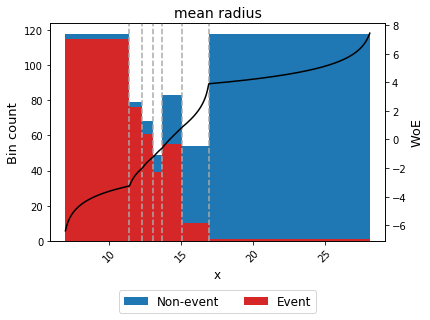

In [12]:
binning_table.plot(metric="woe")

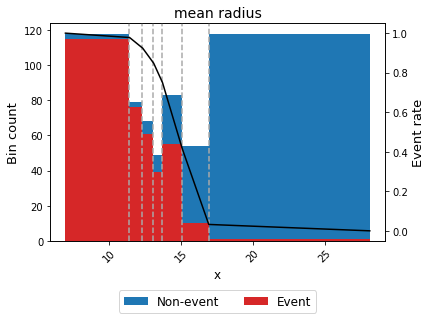

In [13]:
binning_table.plot(metric="event_rate")

##### Event rate / WoE transformation

Now that we have checked the binned data, we can transform our original data into WoE or event rate values.

In [14]:
x_transform_woe = optb.transform(x, metric="woe")

In [15]:
x_transform_event_rate = optb.transform(x, metric="event_rate")

## Advanced

#### Optimal binning Information

The ``OptimalPWBinning`` can print overview information about the options settings, problem statistics, and the solution of the computation. By default, ``print_level=1``.

In [16]:
optb = OptimalPWBinning(name=variable)
optb.fit(x, y)

OptimalPWBinning(estimator=LogisticRegression(), name='mean radius')

If ``print_level=0``, a minimal output including the header, variable name, status, and total time are printed.

In [17]:
optb.information(print_level=0)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean radius                     
  Status  : OPTIMAL                         

  Time    : 0.1102  sec



If ``print_level>=1``, statistics on the pre-binning phase and the solver are printed. More detailed timing statistics are also included.

In [18]:
optb.information(print_level=1)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean radius                     
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of bins                         7

  Solver statistics
    Type                                auto
    Number of variables                   14
    Number of constraints                 20

  Timing
    Total time                          0.11 sec
    Pre-processing                      0.00 sec   (  0.32%)
    Estimator                           0.03 sec   ( 24.05%)
    Pre-binning                         0.05 sec   ( 44.18%)
    Solver                              0.03 sec   ( 23.36%)
    Post-processing                     0.01 sec   (  7.15%)



If ``print_level=2``, the list of all options of the ``OptimalBinning`` are displayed.

In [19]:
optb.information(print_level=2)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                         mean radius   * U
    estimator                            yes   * U
    objective                             l2   * d
    degree                                 1   * d
    continuous                          True   * d
    prebinning_method                   cart   * d
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    monotonic_trend                     auto   * d
    n_subsamples                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    outlier_detector                      no   * d
    outlier_params 

#### Binning table statistical analysis

The ``analysis`` method performs a statistical analysis of the binning table, computing the statistics Gini index, Information Value (IV), Jensen-Shannon divergence, and the quality score. Additionally, several statistical significance tests between consecutive bins of the contingency table are performed: a frequentist test using the Chi-square test or the Fisher's exact test, and a Bayesian A/B test using the beta distribution as a conjugate prior of the Bernoulli distribution. The piecewise binning also includes two performance metrics: the average precision and the Brier score.

In [20]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.87503303
    IV (Jeffrey)             4.47808263
    JS (Jensen-Shannon)      0.37566002
    Hellinger                0.44267970
    Triangular               1.20862637
    KS                       0.72390466
    Avg precision            0.95577179
    Brier score              0.08956351
    HHI                      0.15727342
    HHI (normalized)         0.05193260
    Cramer's V               0.80066760
    Quality score            0.00000000

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1     0.289789 5.903557e-01  0.697563 3.024368e-01
        1      2     2.285355 1.306002e-01  0.941469 5.853092e-02
        2      3     2.317546 1.279217e-01  0.936661 6.333919e-02
        3      4     2.539025 1.110634e-01  0.950869 4.913141e-02
        4

In [21]:
binning_table.analysis(pvalue_test="fisher")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.87503303
    IV (Jeffrey)             4.47808263
    JS (Jensen-Shannon)      0.37566002
    Hellinger                0.44267970
    Triangular               1.20862637
    KS                       0.72390466
    Avg precision            0.95577179
    Brier score              0.08956351
    HHI                      0.15727342
    HHI (normalized)         0.05193260
    Cramer's V               0.80066760
    Quality score            0.00000000

  Significance tests

    Bin A  Bin B  odd ratio      p-value  P[A > B]     P[B > A]
        0      1   0.660870 6.855009e-01  0.697563 3.024368e-01
        1      2   0.343985 1.879769e-01  0.941469 5.853092e-02
        2      3   0.447541 1.829850e-01  0.936661 6.333919e-02
        3      4   0.503663 1.153088e-01  0.950869 4.913141e-02
        4      5   

#### Event rate / WoE monotonicity

The ``monotonic_trend`` option permits forcing a monotonic trend to the event rate curve. The default setting "auto" should be the preferred option, however, some business constraints might require to impose different trends. The default setting "auto" chooses the monotonic trend most likely to maximize the information value from the options "ascending", "descending", "peak" and "valley" using a machine-learning-based classifier. For this example, we choose Gradient Boosting as an estimator.

In [22]:
variable = "mean texture"
x = df[variable].values
y = data.target

In [23]:
optb = OptimalPWBinning(name=variable, estimator=GradientBoostingClassifier())
optb.fit(x, y, lb=0.001, ub=0.999)

OptimalPWBinning(estimator=GradientBoostingClassifier(), name='mean texture')

In [24]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,c0,c1
0,"(-inf, 15.05)",92,0.161687,4,88,0.931559,-0.000000
1,"[15.05, 16.39)",61,0.107206,8,53,2.075863,-0.076059
2,"[16.39, 17.03)",29,0.050967,6,23,2.149342,-0.080541
3,"[17.03, 18.46)",79,0.138840,17,62,1.113793,-0.019751
4,"[18.46, 19.47)",55,0.096661,20,35,4.139964,-0.183682
5,"[19.47, 20.20)",36,0.063269,18,18,4.417902,-0.197957
6,"[20.20, 21.71)",72,0.126538,43,29,0.933414,-0.025415
7,"[21.71, 22.74)",40,0.070299,27,13,2.611206,-0.102697
8,"[22.74, 24.00)",29,0.050967,24,5,0.275868,-0.000000
9,"[24.00, 26.98)",43,0.075571,30,13,-1.111300,0.057799


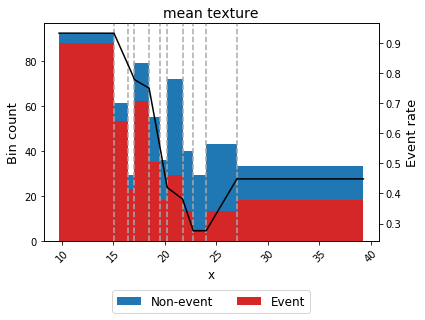

In [25]:
binning_table.plot(metric="event_rate")

For example, we can force the variable mean texture to be convex with respect to the probability of having breast cancer.

In [26]:
optb = OptimalPWBinning(name=variable, estimator=GradientBoostingClassifier(),
                        monotonic_trend="convex")
optb.fit(x, y, lb=0.001, ub=0.999)

OptimalPWBinning(estimator=GradientBoostingClassifier(),
                 monotonic_trend='convex', name='mean texture')

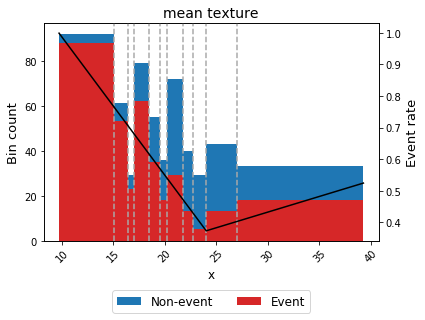

In [27]:
binning_table = optb.binning_table
binning_table.build()
binning_table.plot(metric="event_rate")

#### User-defined split points

In some situations, we have defined split points or bins required to satisfy a priori belief,  knowledge or business constraint. The ``OptimalPWBinning`` permits to pass user-defined split points. The supplied information is used as a pre-binning, disallowing any pre-binning method set by the user. Furthermore, version 0.5.0 introduces ``user_splits_fixed`` parameter, to allow the user to fix some user-defined splits, so these must appear in the solution.

Example numerical variable:

In [28]:
user_splits =       [  14,    15,    16,    17,    20,    21,    22,    27]
user_splits_fixed = [False, True,  True, False, False, False, False, False]

In [29]:
optb = OptimalPWBinning(name=variable, user_splits=user_splits,
                        user_splits_fixed=user_splits_fixed)

optb.fit(x, y)

OptimalPWBinning(estimator=LogisticRegression(), name='mean texture',
                 user_splits=[14, 15, 16, 17, 20, 21, 22, 27],
                 user_splits_fixed=[False, True, True, False, False, False,
                                    False, False])

In [30]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,c0,c1
0,"(-inf, 14.00)",54,0.094903,2,52,1.153974,-0.020565
1,"[14.00, 15.00)",37,0.065026,2,35,1.354515,-0.034890
2,"[15.00, 16.00)",43,0.075571,7,36,1.244455,-0.027552
3,"[16.00, 20.00)",210,0.369069,59,151,1.570900,-0.047955
4,"[20.00, 21.00)",45,0.079086,26,19,1.874636,-0.063142
5,"[21.00, 22.00)",49,0.086116,30,19,1.788369,-0.059034
6,"[22.00, 27.00)",99,0.173989,71,28,1.708444,-0.055401
7,"[27.00, inf)",32,0.056239,15,17,0.789092,-0.021351
8,Special,0,0.000000,0,0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.000000


In [31]:
optb.information()

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : mean texture                    
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of bins                         8

  Solver statistics
    Type                                auto
    Number of variables                   16
    Number of constraints                 23

  Timing
    Total time                          0.26 sec
    Pre-processing                      0.00 sec   (  0.26%)
    Estimator                           0.02 sec   (  8.04%)
    Pre-binning                         0.13 sec   ( 49.40%)
    Solver                              0.10 sec   ( 38.54%)
    Post-processing                     0.01 sec   (  3.13%)



#### Performance: choosing a solver

``OptimalPWBinning`` uses the RoPWR library to solving the piecewise regression problem. See https://github.com/guillermo-navas-palencia/ropwr for details.

#### Robustness: choosing an objective function and regularization

``OptimalPWBinning`` uses the RoPWR library to solving the piecewise regression problem. See https://github.com/guillermo-navas-palencia/ropwr for details.

#### Missing data and special codes

For this example, let's load data from the FICO Explainable Machine Learning Challenge: https://community.fico.com/s/explainable-machine-learning-challenge

In [32]:
df = pd.read_csv("data/FICO_challenge/heloc_dataset_v1.csv", sep=",")

The data dictionary of this challenge includes three special values/codes:

* -9 No Bureau Record or No Investigation
* -8 No Usable/Valid Trades or Inquiries
* -7 Condition not Met (e.g. No Inquiries, No Delinquencies) 

Version 0.16.0 added support to treat special codes separately.

In [33]:
special_codes = {'special_9': -9, 'special_8': -8, 'special_7': -7}

In [34]:
variable = "AverageMInFile"
x = df[variable].values
y = df.RiskPerformance.values

In [35]:
df.RiskPerformance.unique()

array(['Bad', 'Good'], dtype=object)

Target is a categorical dichotomic variable, which can be easily transform into numerical.

In [36]:
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

In [37]:
x[10:20] = -8
x[100:105] = -7

For the sake of completeness, we include a few missing values

In [38]:
idx = np.random.randint(0, len(x), 500)
x = x.astype(float)
x[idx] = np.nan

In [39]:
optb = OptimalPWBinning(name=variable, special_codes=special_codes, solver="osqp")

optb.fit(x, y, lb=0, ub=1)

OptimalPWBinning(estimator=LogisticRegression(), name='AverageMInFile',
                 solver='osqp',
                 special_codes={'special_7': -7, 'special_8': -8,
                                'special_9': -9})

In [40]:
optb.information(print_level=1)

optbinning (Version 0.18.0)
Copyright (c) 2019-2023 Guillermo Navas-Palencia, Apache License 2.0

  Name    : AverageMInFile                  
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of bins                        12

  Solver statistics
    Type                                osqp
    Number of variables                   24
    Number of constraints              18837

  Timing
    Total time                          0.51 sec
    Pre-processing                      0.00 sec   (  0.38%)
    Estimator                           0.04 sec   (  8.71%)
    Pre-binning                         0.18 sec   ( 35.60%)
    Solver                              0.26 sec   ( 50.91%)
    Post-processing                     0.02 sec   (  4.01%)



In [41]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,c0,c1
0,"(-inf, 30.50)",550,0.052586,99,451,0.791441,-0.003079
1,"[30.50, 41.50)",546,0.052204,147,399,0.803517,-0.003475
2,"[41.50, 48.50)",509,0.048666,144,365,0.807561,-0.003572
3,"[48.50, 54.50)",528,0.050483,184,344,0.813022,-0.003685
4,"[54.50, 59.50)",483,0.046180,191,292,0.816973,-0.003757
5,"[59.50, 64.50)",604,0.057749,257,347,0.819004,-0.003791
6,"[64.50, 69.50)",645,0.061669,298,347,0.826512,-0.003908
7,"[69.50, 74.50)",672,0.064251,331,341,0.811102,-0.003686
8,"[74.50, 81.50)",900,0.086050,474,426,0.863326,-0.004387
9,"[81.50, 97.50)",1685,0.161105,954,731,0.772491,-0.003273


Note the dashed bins 10 and 11, corresponding to the special codes bin and the missing bin, respectively.

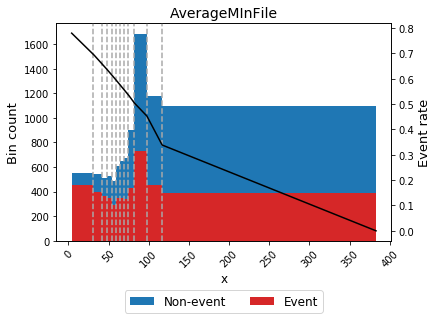

In [42]:
binning_table.plot(metric="event_rate")

#### Verbosity option

For debugging purposes, we can print information on each step of the computation by triggering the ``verbose`` option.

In [43]:
optb = OptimalPWBinning(name=variable, solver="osqp", verbose=True)
optb.fit(x, y, lb=0, ub=1)

2022-10-23 15:50:03,172 | INFO : Optimal piecewise binning started.
2022-10-23 15:50:03,174 | INFO : Options: check parameters.
2022-10-23 15:50:03,176 | INFO : Pre-processing started.
2022-10-23 15:50:03,178 | INFO : Pre-processing: number of samples: 10459
2022-10-23 15:50:03,180 | INFO : Pre-processing: number of clean samples: 9973
2022-10-23 15:50:03,182 | INFO : Pre-processing: number of missing samples: 486
2022-10-23 15:50:03,183 | INFO : Pre-processing: number of special samples: 0
2022-10-23 15:50:03,185 | INFO : Pre-processing terminated. Time: 0.0005s
2022-10-23 15:50:03,186 | INFO : Pre-binning: set logistic regression as an estimator.
2022-10-23 15:50:03,188 | INFO : Pre-binning: estimator fitting started.
2022-10-23 15:50:03,257 | INFO : Pre-binning: estimator terminated. Time 0.0704s.
2022-10-23 15:50:03,258 | INFO : Pre-binning: optimal binning started.
2022-10-23 15:50:03,471 | INFO : Pre-binning: number of splits: 9.
2022-10-23 15:50:03,473 | INFO : Pre-binning: no n

OptimalPWBinning(estimator=LogisticRegression(), name='AverageMInFile',
                 solver='osqp', verbose=True)